# Investigating bug (Issue #2101) 
- in conftest getting default cifar10 subset (and mnist) for PyTorch framework is incorrect
- should be using __transpose__ instead of __reshape__

### Example of bug

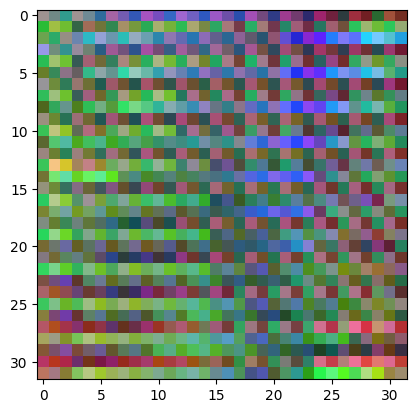

In [12]:
from art.utils import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

cifar10_shape = (3, 32, 32)

(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10), _, _ = load_dataset("cifar10")

x_train_cifar10 = np.reshape(x_train_cifar10, (x_train_cifar10.shape[0],) + cifar10_shape).astype(np.float32)
x_test_cifar10 = np.reshape(x_test_cifar10, (x_test_cifar10.shape[0],) + cifar10_shape).astype(np.float32)

n_train, n_test = (10, 10)

x_train_cifar10 = np.reshape(x_train_cifar10, (x_train_cifar10.shape[0],) + cifar10_shape).astype(np.float32)
x_test_cifar10 = np.reshape(x_test_cifar10, (x_test_cifar10.shape[0],) + cifar10_shape).astype(np.float32)

x_test_cifar10 = x_test_cifar10[0:n_test]

plt.imshow(x_test_cifar10[0].transpose(1,2,0))

### The fix - using transpose

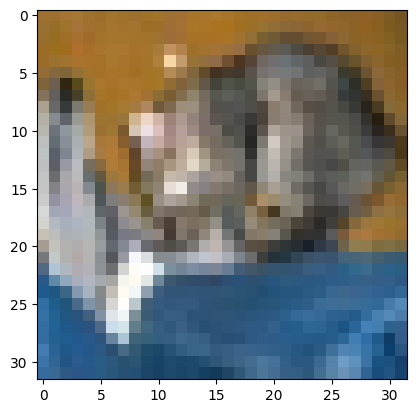

In [27]:
from art.utils import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import torch

# shape returned will match the framework reqs
cifar10_shape = (3,32,32)

(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10), _, _ = load_dataset("cifar10")

# Remove the first reshape as unnecessary

n_train, n_test = (10, 10)

# transpose instead of reshape
if np.argmin(cifar10_shape)==0:
    x_train_cifar10 = x_train_cifar10.transpose(0, 3, 1, 2).astype(np.float32)
    x_test_cifar10 = x_test_cifar10.transpose(0, 3, 1, 2).astype(np.float32)
    
# the get default subset function
if np.argmin(cifar10_shape)==0 and not np.argmin(x_train_cifar10.shape[1:])==0:
        x_train_cifar10 = x_train_cifar10.transpose(0, 3, 1, 2)
        x_test_cifar10 = x_test_cifar10.transpose(0, 3, 1, 2)

x_test_cifar10 = x_test_cifar10[0:n_test]

plt.imshow(x_test_cifar10[0].transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


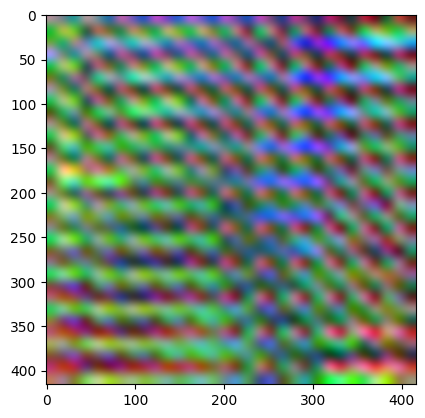

In [3]:
import cv2
import torch

from pytorchyolo import models
from pytorchyolo.utils.loss import compute_loss

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo

model_path = "../yolov3.cfg"
weights_path = "../yolov3.weights"
model = models.load_model(model_path=model_path, weights_path=weights_path)

class YoloV3(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model(x)
            # loss is averaged over a batch. Thus, for patch generation use batch_size = 1
            loss, _ = compute_loss(outputs, targets, self.model)

            loss_components = {"loss_total": loss}

            return loss_components
        else:
            return self.model(x)

model = YoloV3(model)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

object_detector = PyTorchYolo(
    model=model,
    input_shape=(3, 416, 416),
    #optimizer=optimizer,
    clip_values=(0, 1),
    channels_first=True,
    attack_losses=("loss_total",),
)


x_test = cv2.resize(
    x_test_cifar10[0].transpose((1, 2, 0)), dsize=(416, 416), interpolation=cv2.INTER_CUBIC
).transpose((2, 0, 1))
x_test = np.expand_dims(x_test, axis=0)
x_test = np.repeat(x_test, repeats=2, axis=0)

# Create labels
plt.imshow(x_test[0].transpose(1,2,0))
result = object_detector.predict(x=x_test)

y_test = [
    {
        "boxes": result[0]["boxes"],
        "labels": result[0]["labels"],
        "scores": np.ones_like(result[0]["labels"]),
    },
    {
        "boxes": result[1]["boxes"],
        "labels": result[1]["labels"],
        "scores": np.ones_like(result[1]["labels"]),
    },
]

### Testing similar for mnist

original


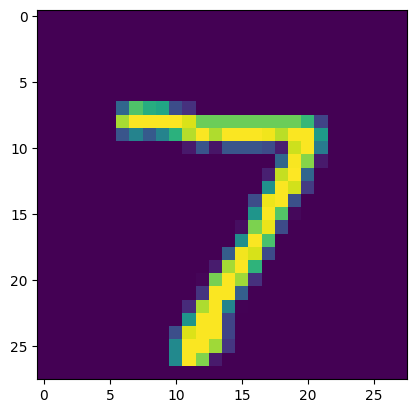

In [6]:
mnist_shape = (1,28,28)

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), _, _ = load_dataset("mnist")

'''x_train_mnist = x_train_mnist.transpose(0, 3, 1, 2)
x_test_mnist = x_test_mnist.transpose(0, 3, 1, 2)'''

x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0],) + mnist_shape).astype(np.float32)
x_test_mnist = np.reshape(x_test_mnist, (x_test_mnist.shape[0],) + mnist_shape).astype(np.float32)

n_train, n_test = (10, 10)

x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0],) + mnist_shape).astype(np.float32)
x_test_mnist = np.reshape(x_test_mnist, (x_test_mnist.shape[0],) + mnist_shape).astype(np.float32)

print('original')
plt.imshow(x_test_mnist[0].transpose(1,2,0))
original = x_test_mnist[0].transpose(1,2,0)

with fix


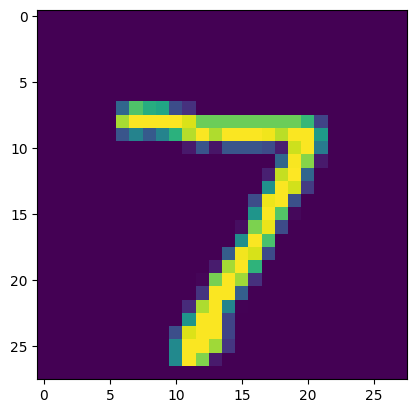

In [7]:
mnist_shape = (1,28,28)

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), _, _ = load_dataset("mnist")

x_train_mnist = x_train_mnist.transpose(0, 3, 1, 2)
x_test_mnist = x_test_mnist.transpose(0, 3, 1, 2)

n_train, n_test = (10, 10)

print('with fix')
plt.imshow(x_test_mnist[0].transpose(1,2,0))
compare = x_test_mnist[0].transpose(1,2,0)

In [8]:
np.equal(original, compare).all()

False